In this notebook, we would like to introduce Imported and Computed tables that allow automatic processing.
We are using a simple calcium imaging pipeline as an example.

# Import the module that defines the upstream tables

To set up a simple calcium imaging data pipeline, we will extend the previous pipeline created in notebook 01. Let's first import a pre-prepared module that contains the table definition.

In [2]:
import experiment

Take a quick look at the tables Mouse and Session

In [3]:
experiment.Mouse()

mouse_id Unique animal ID,dob date of birth,sex sex,mouse_notes other comments and distinguishing features
0,2019-01-05,M,
1,2020-01-06,M,
2,2019-08-23,M,
3,2020-01-22,F,


In [4]:
experiment.Session()

mouse_id Unique animal ID,session_number session number,session_date date,person researcher name,data_path file path for TIFF stacks
0,1,2019-12-03,Shan,data
1,1,2020-03-02,Thinh,data


# Define table `Scan` for meta information of each calcium imaging scan

Now let's define a table Scan that describe a scanning in an experimental session that stores the meta information of a particular scan.

In [6]:
import datajoint as dj

# still using the same schema
schema = dj.schema('shan_calcium')

@schema
class Scan(dj.Manual):
    definition = """
    -> experiment.Session
    scan_idx    : int           # scan index
    ---
    depth       : float         # depth of this scan
    wavelength  : float         # wavelength used
    laser_power : float         # power of the laser used
    fps         : float         # frames per second
    file_name    : varchar(128) # name of the tif file
    """

This table is dependent on the table `experiment.Session`, inheriting its primary key attributes, with an additional primary key attribute `scan_idx`. One session could contain multiple scans, which is another example of one-to-many relationship. We could take a look at the ERD again.

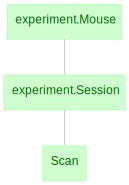

In [15]:
dj.ERD(experiment) + Scan

The `____` indicates additional primary key attributes apart from the ones inherited from its parents.

Here we have two tif files of scanning in the `data` folder `example_scan_01.tif` and `example_scan_02.tif` 

Let's insert these meta information manually.

In [14]:
Scan.insert([
    {'mouse_id': 0, 'session_number': 1, 'scan_idx': 1, 
     'depth': 150, 'wavelength': 920, 'laser_power': 26, 'fps': 15, 'file_name': 'example_scan_01.tif'},
    {'mouse_id': 0, 'session_number': 1, 'scan_idx': 2, 
     'depth': 200, 'wavelength': 920, 'laser_power': 24, 'fps': 15, 'file_name': 'example_scan_02.tif'},
])

In [23]:
Scan()

mouse_id Unique animal ID,session_number session number,scan_idx scan index,depth depth of this scan,wavelength wavelength used,laser_power power of the laser used,fps frames per second,file_name name of the tif file
0,1,1,150.0,920.0,26.0,15.0,example_scan_01.tif
0,1,2,200.0,920.0,24.0,15.0,example_scan_02.tif


# Imported table for average fluorescence across frames

Let's first load one raw data and take a look at the data:

In [98]:
from skimage import io
im = io.imread('data/example_scan_01.tif')
print(im.shape)

(100, 128, 128)


This tiff file contains 100 frames. Let's take the average of the images over frames.

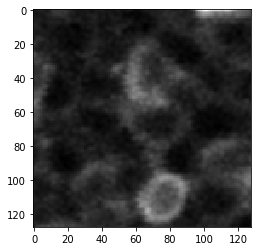

In [38]:
import numpy as np
import matplotlib.pyplot as plt
avg_image = np.mean(im, axis=0)
plt.imshow(avg_image, cmap=plt.cm.gray)

Now let's create a table `AverageFluorescence` to compute and save the average fluorescence. 

Here we introduce a new type of table **imported** table, that allows auto processing of each dataset. Similar as the manual table, an imported table is created by declaring a class, but this time, the class need to inherit another datajoint class, `dj.Imported`. This class allows definition of a special method `make`, where the computation for one data set could be defined.

In [44]:
import os
@schema
class AverageFluorescence(dj.Imported):
    definition = """
    -> Scan
    ---
    average_fluorescence   : longblob     # average fluorescence across frames
    """
    def make(self, key):  # key is the primary key of one of the entries in the table `Scan`
        # fetch data directory from table Session
        data_path = (experiment.Session & key).fetch1('data_path')
        
        # fetch data file name from table Scan
        file_name = (Scan & key).fetch1('file_name')
        
        # load the file
        im = io.imread(os.path.join(data_path, file_name))
        # compute the average image across the frames
        avg_image = np.mean(im, axis=0)
        
        # Now prepare the entry as a dictionary with all fields defined in the table.
        entry = dict(**key, average_fluorescence=avg_image) # inherit the primary key from the table Scan
        
        # insert entry with the method `insert1()`
        self.insert1(entry)

This table shares the exact same primary key as the table `Scan`. The `make` function takes a single primary key of an entry in the table `Scan`. It is called by a method called `populate` that does two things:
1. From the table definition, get the query that needs to computed, which we called `key_source`, as a property of the current table. By default, it would be the join result of the primary dependent tables. The actual entries that are populated are the `key_source` minus the ones that have been computed before. 
2. Call `make` function defined in the class, and compute one by one, with each individual key from the `key_source`

In [42]:
AverageFluorescence.key_source

mouse_id Unique animal ID,session_number session number,scan_idx scan index
0,1,1
0,1,2


In [45]:
AverageFluorescence.populate(display_progress=True) # argument `display_progress` shows the progress when populating.

100%|██████████| 2/2 [00:02<00:00,  1.53s/it]


There were two entries that were populated, consistent with the `key_source`, but if we call `populate` again, there are no more entries populated, because they've already been populated.

In [47]:
AverageFluorescence.populate(display_progress=True)

0it [00:00, ?it/s]


Now instead of loading from the raw tif file, we are able fetch the average fluorescence image from this table.

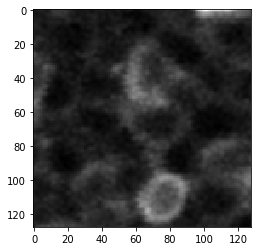

In [73]:
avg_images = AverageFluorescence.fetch('average_fluorescence')
plt.imshow(avg_images[0], cmap=plt.cm.gray)

# Advanced: Lookup table, Computed table, and Part table

Now let's perform the segmentation to isolate regions of interest (ROIs). To keep it simple, we just detect the cells by setting up the threshold on the average image. The outcome is different across different threholds we set. Therefore, this threshold is a parameter we could potentially tweak.

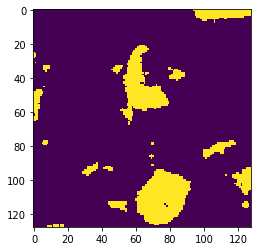

In [59]:
th = 50
mask = avg_image > th
plt.imshow(mask)

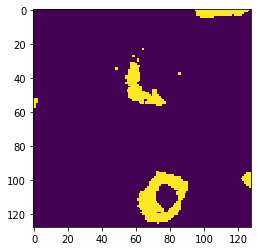

In [61]:
th = 60
mask = avg_image > th
plt.imshow(mask)

Now we could use scipy.ndimage to detect the blobs from this binary mask

For the detailed tutorial, please refer to https://scipy-lectures.org/advanced/image_processing/index.html#segmentation

In [56]:
from scipy import ndimage

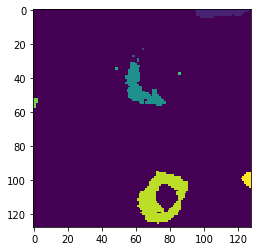

In [63]:
label_im, nb_labels = ndimage.label(mask)
plt.imshow(label_im) 

We could filter out the smaller blobs, here, the cutoff of the size is another parameter we could tweak.

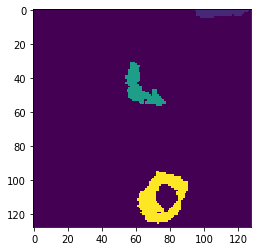

In [65]:
# filter out smaller blobs
sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))

size_cutoff = 50
mask_size = sizes < size_cutoff
remove_pixel = mask_size[label_im]

label_im[remove_pixel] = 0
plt.imshow(label_im)

In [66]:
# separate out each mask.
rois = []
for i in np.unique(label_im)[1:]:
    rois.append(label_im == i)

Let's take a look at an example of the mask

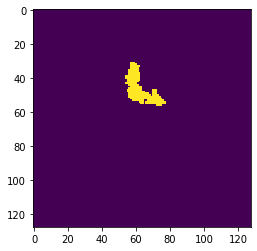

In [67]:
plt.imshow(rois[1])

Ideally, we would like to perform the segmentation with each average image, and each combination of parameters, threshold and size cutoff. Then we could compare the results of each parameter combination. DataJoint provides features that keep track of all parameter combinations.

## Lookup table for parameter sets

In [74]:
@schema
class ParameterSet(dj.Lookup):
    definition = """
    parameter_set_id    : int
    ---
    threshold           : float
    size_cutoff         : float
    """
    contents = [
        [0, 50., 50.],
        [1, 60., 50.],
        [2, 50., 30.]
    ]

The lookup table inherits `dj.Lookup`. We could cuse this lookup table to save the values of each parameter combination. The definition part is the same as the manual table and imported table introduced previously. Additionally, it has a special property `contents` that allows direct insertion when declaring the class.

In [75]:
ParameterSet()

parameter_set_id,threshold,size_cutoff
0,50.0,50.0
1,60.0,50.0
2,50.0,30.0


## Computed table and Part table for Segmentation and ROI

We will create a **computed** table to process and save results of the segmentation. The Computed table is very similar to the imported table and also supports definition of computation and auto-processing. The only difference is that all data needed for the computation is from the database and does not rely on external data files.


We would like the segmentation to be performed for each combination of parameters and each datasets. Therefore, the primary key of this table refers to both `AverageFluorescence` and `ParameterSet`.

The final product of the segmentation analyses is the mask of ROIs. To save the result on the level of each individual ROI, we will use a **part** table `Roi`. In addition to the primary key of its master `Segmentation`, the table `Roi` has an extra primary key attribute roi_idx. The computation and insertion were performed by its master table `Segmentation`.

In [77]:
@schema
class Segmentation(dj.Computed):
    definition = """
    -> AverageFluorescence
    -> ParameterSet
    ---
    segmented_masks         : longblob   # overview of segmented masks
    """
    def make(self, key): # key is one of the primary keys of the join product of AverageFluorescence and ParameterSet
        
        # fetch average image from the previous table AverageFluorescence
        avg_image = (AverageFluorescence & key).fetch1('average_fluorescence')
        
        # fetch the parameters threshold and size_cutoff
        threshold, size_cutoff = (ParameterSet & key).fetch1(
            'threshold', 'size_cutoff')
        
        # perform the thresholding and blob detection
        mask = avg_image > threshold
        label_im, nb_labels = ndimage.label(mask)
        sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
        mask_size = sizes < size_cutoff
        remove_pixel = mask_size[label_im]
        label_im[remove_pixel] = 0
        rois = [dict(**key, roi_idx=i, mask=label_im==label) for i, label in enumerate(np.unique(label_im)[1:])]
        
        self.insert1(
            dict(**key, segmented_masks=label_im)
        )
        self.Roi.insert(rois)
        
    class Roi(dj.Part):
        definition = """
        -> master
        roi_idx             : int        # index of an roi
        ---
        mask                : longblob   # mask of this roi
        """

The benefit of having Part table here is to only import the average image once and get all segmentations ingested. The part table is not necessary if no results of smaller granularies are saved.

Now let's get the table populated

In [78]:
Segmentation.populate(display_progress=True)

100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


There are 6 entries got populated:

In [82]:
Segmentation()

mouse_id Unique animal ID,session_number session number,scan_idx scan index,parameter_set_id,segmented_masks overview of segmented masks
0,1,1,0,=BLOB=
0,1,2,0,=BLOB=
0,1,1,1,=BLOB=
0,1,2,1,=BLOB=
0,1,1,2,=BLOB=
0,1,2,2,=BLOB=


In [83]:
Segmentation.Roi()

mouse_id Unique animal ID,session_number session number,scan_idx scan index,parameter_set_id,roi_idx index of an roi,mask mask of this roi
0,1,1,0,0,=BLOB=
0,1,1,0,1,=BLOB=
0,1,1,0,2,=BLOB=
0,1,1,0,3,=BLOB=
0,1,1,0,4,=BLOB=
0,1,1,0,5,=BLOB=
0,1,1,1,0,=BLOB=
0,1,1,1,1,=BLOB=
0,1,1,1,2,=BLOB=
0,1,1,2,0,=BLOB=


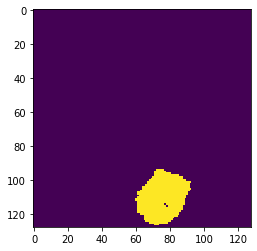

In [89]:
# show one example ROI
mask = (Segmentation.Roi & dict(mouse_id=0, 
                                session_number=1, 
                                scan_idx=1, 
                                parameter_set_id=0, 
                                roi_idx=5)).fetch1('mask')
plt.imshow(mask)

# Fluorescence trace of each segmented ROI

Now we got masks of ROIs in the table `Segmetation.Roi` obtained with different parameter combinations. We would like to extract the fluorescence trace of each segmentation.

In [121]:
@schema
class Fluorescence(dj.Imported): # imported table because it also rely on the external tiff file.
    definition = """
    -> Segmentation
    ---
    time    : longblob    # time for each frame
    """
    
    # the master table is mainly to perform the computation, while the part table contains the result
    def make(self, key):
        
        
        
        # fetch data directory from table Session
        data_path = (experiment.Session & key).fetch1('data_path')
        
        # fetch data file name from table Scan
        file_name = (Scan & key).fetch1('file_name')
        
        # load the file
        im = io.imread(os.path.join(data_path, file_name))
        
        # get dimensions of the image and reshape
        n, w, h = np.shape(im)
        im_reshaped = np.reshape(im, [n, w*h])
        
        # get frames per second to compute time
        fps = (Scan & key).fetch1('fps')
        
        # insert into master table first
        self.insert1(dict(**key, time=np.array(range(n))/fps))
        
        
        # extract traces
        roi_keys, masks = (Segmentation.Roi & key).fetch('KEY', 'mask')
        
        traces = []
        for roi_key, mask in zip(roi_keys, masks):
            
            # reshape mask
            mask_reshaped = np.reshape(mask, [w*h])
            trace = np.mean(im_reshaped[:, mask_reshaped], axis=1)
            
            traces.append(dict(**roi_key, trace=trace))
        
        self.Trace.insert(traces)
        
    class Trace(dj.Part):
        definition = """
        -> master
        -> Segmentation.Roi
        ---
        trace      :  longblob    # fluorescence trace of each ROI
        """
        

In [122]:
Fluorescence.populate(display_progress=True)

100%|██████████| 6/6 [00:58<00:00, 10.50s/it]


Now we could plot the traces of a single scan with a certain combination of parameters.

Text(0, 0.5, 'Fluorescence')

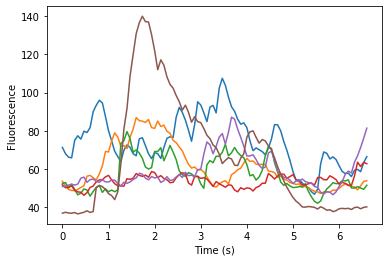

In [138]:
key = dict(mouse_id=0, session_number=1, scan_idx=1, parameter_set_id=0)

time = (Fluorescence & key).fetch1('time')
traces = (Fluorescence.Trace & key).fetch('trace')

plt.plot(time, np.vstack(traces).T)
plt.xlabel('Time (s)')
plt.ylabel('Fluorescence')